In [1]:
!pip install -q ipyleaflet scipy

import itertools
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets

from scipy.cluster.hierarchy import linkage, dendrogram
from collections import defaultdict
from util import dataset
from util.geo import mean_latlong, latlong_from_3d, latlong_to_3d, euclidian_dist, haversine_dist

from ipyleaflet import Marker, Map, CircleMarker, MarkerCluster, LayerGroup

## Inferir lugar do usuários

- Faz join entre business, review e tip para saber a lat/lng de todas as iterações do usuário
- Clusteriza iterações de cada usuário, onde eventos a menos de 10km de distancia pertencem ao mesmo cluster
- Associa usuário ao centróide do cluster mais denso

### Escolha do cluster

Estou usando uma clusterização hierárquica do tipo `Ward`, a qual prioriza a escolha de clusteres densos.

Ela funciona muito bem para este problema, e possui uma propriedade muito interessante:
- Numa distribuição com densidade uniforme, o custo ~ número de elementos
- Portanto a densidade pode ser estimada por `n / cost`.

Infelizmente, a escolha do cluster não é tão simples quanto pegar o cluster mais denso, pois os clusteres mais densos são também os menores (Um elemento sozinha possui densidade ∞). Um pequeno cluster extremamente denso não deve ser escolhido quando 80% dos pontos estão do outro lado do país.

#### Critério 1
A primeira solução envolve algumas heuristicas:
- Considerar apenas clusters com pelo menos 10% dos pontos e custo não-zero
- Favorecer clusteres maiores, alterando a formula para `√n / cost`.

#### Critério 2
A segunda solução, também heuristica, funciona de maneira diferente:
- Começando pelo último cluster da hierarquia (Que possui todos os elementos)
- Enquanto algum dos sub-clusteres possui mais de 60% dos elementos
  - descarta o sub-cluster menor

Ambas as soluções funcionam bem e são razoávelmente consistentes na maioria dos casos (Mas não em todos)

O [Jörn's Blog](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Selecting-a-Distance-Cut-Off-aka-Determining-the-Number-of-Clusters) sugere algumas outras formas interessantes de escolher a profundidade da clusterização

In [2]:
user_names = {
    user['user_id']: user['name']
    for user in dataset.read('user')
}
len(user_names)

1518168

In [3]:
business_latlng = {
    x['business_id']: (x['latitude'], x['longitude'])
    for x in dataset.read('business')
    if x['latitude'] is not None and x['longitude'] is not None
}

In [4]:
user_locs = defaultdict(list)
for row in itertools.chain(dataset.read('tip'), dataset.read('review')):
    loc = business_latlng.get(row['business_id'], None)
    if loc is not None:
        user_locs[row['user_id']].append(loc)
len(user_locs)

1518142

In [5]:
user_locs = {
    user_id: np.array(locs)
    for user_id, locs in user_locs.items()
}

In [53]:
user_locs_big = {
    id: locs
    for id, locs in user_locs.items()
    if len(locs) > 1000
}
len(user_locs_big)

50

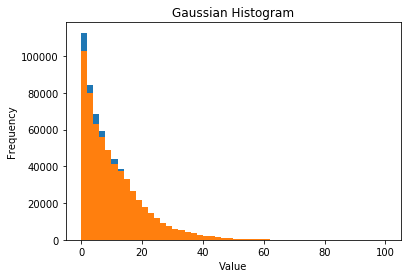

In [7]:
dists1=[]
dists2=[]
for user, locs in user_locs_big.items():
    for i1, loc1 in enumerate(locs):
        for loc2 in locs[i1+1:]:
            try:
                dists1.append(haversine_dist(loc1, loc2))
                dists2.append(euclidian_dist(latlong_to_3d(loc1), latlong_to_3d(loc2)))
            except:
                print(loc1, loc2)
                raise



plt.hist(np.array(dists2) * .9, 50, range=(0,100))
plt.hist(dists1, 50, range=(0,100))
plt.title("Gaussian Histogram")
plt.xlabel("Value")
#plt.xscale('log')
plt.ylabel("Frequency")
plt.show()

In [8]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        #plt.loglog()
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [51]:
import math

def find_cluster_home(points):
    points_3d = np.array([latlong_to_3d(point) for point in points])
    
    links = linkage(points_3d, method='ward')
    n_nodes = len(points_3d)
    clusters = [
        {'n': 1, 'cost': 0, 'nodes': np.array([point]), 'parents': None}
        for point in points_3d
    ]
    for link in links:
        a = clusters[int(link[0])]
        b = clusters[int(link[1])]
        cost = link[2]
        clusters.append({
            'n': a['n'] + b['n'],
            'cost': cost,
            'nodes': np.concatenate([a['nodes'], b['nodes']]), 
            'parents': (int(link[0]), int(link[1])),
            #'goodness': (a['cost'] + b['cost']) / cost,
        })
                                           
    for cluster in clusters:
        cluster['goodness'] = cluster['cost'] / (cluster['n'] + 1)**.5

    best_cluster1 = min(clusters, key=lambda x: x['goodness'] if x['n'] > n_nodes/10 and x['cost'] > 0 else math.inf)
    best_cluster1 = latlong_from_3d(best_cluster1['nodes'].mean(axis=0))

    if False:
        scatter = np.array([
            (cluster['n'] + 1e-5, cluster['cost'], cluster['goodness'])
            for i, cluster in enumerate(clusters)
            if i >= n_nodes
        ])
        #plt.scatter(scatter[:,0], scatter[:,1])
        plt.xlabel('N')
        plt.ylabel('cost')
        plt.show()
        plt.scatter(scatter[:,0], scatter[:,2])
        plt.xlabel('N')
        plt.ylabel('goodness')
        plt.show()
    
    
    
    best_cluster2 = clusters[-1]
    while True:
        if best_cluster2['parents'] is None:
            break
        a = clusters[best_cluster2['parents'][0]]
        b = clusters[best_cluster2['parents'][1]]
        if a['n'] > .6 * best_cluster2['n']:
            best_cluster2 = a
        elif b['n'] > .6 * best_cluster2['n']:
            best_cluster2 = b
        else:
            break
            
    best_cluster2 = latlong_from_3d(best_cluster2['nodes'].mean(axis=0))
    return best_cluster1, best_cluster2


In [56]:
def show_user_map(locs, map):
    lat_bounds = (locs[:,0].min(), locs[:,0].max())
    lng_bounds = (locs[:,1].min(), locs[:,1].max())
    map.center = (sum(lat_bounds)/2, sum(lng_bounds)/2)
    map.zoom = math.ceil(7.7-math.log2(max(lat_bounds[1]-lat_bounds[0], lng_bounds[1]-lng_bounds[0])))

    home1, home2 = find_cluster_home(locs)
    print('cluster found!')

    marker_cluster = LayerGroup(
        maxClusterRadius=5,
        layers=[
            CircleMarker(
                #title=loc[0],
                location=list(loc), 
                draggable=False,
                radius=5,
                stroke=False,
                fill_opacity=.5,
                #fill_color=matplotlib.colors.to_hex(color)
            )
            for loc in locs
        ])

    marker_home1 = Marker(
        title='Home 1',
        location=home1,
        draggable=False,
    )
    marker_home2 = Marker(
        title='Home 2',
        location=home2, 
        draggable=False,
    )
    return [
        marker_cluster,
        marker_home1,
        marker_home2
    ]

In [79]:
user_selector = widgets.Dropdown(
    options=[
        (user_names[user_id], user_id)
        for user_id in user_locs_big
    ],
    value=next(iter(user_locs_big)),
    description='User',
    disabled=False,
)
user_map = Map(prefer_canvas=True)
user_map_layers = []

output_container = widgets.VBox([])
display(user_selector, user_map, output_container)

def show_user(user_id):
    global user_map_layers
    output = widgets.Output()
    with output:
        for layer in user_map_layers:
            user_map.remove_layer(layer)
        user_map_layers = show_user_map(user_locs[user_id], user_map)
        for layer in user_map_layers:
            user_map.add_layer(layer)
            
    output_container.children = [output]
    
user_selector.observe(lambda event: show_user(event['new']), names='value')
show_user(user_selector.value)


cluster found!


In [74]:
import time
all_user_homes = {}

start_time = time.time()
last_print_time = start_time
for i, (user_id, locs) in enumerate(user_locs.items()):
    if len(locs) > 100:
        all_user_homes[user_id] = find_cluster_home(locs)
        
    now = time.time()
    if now - last_print_time > 1:
        print('%d/%d - %.2f%%' % (i+1, len(user_locs), 100.0 * (i+1) / len(user_locs)))
        last_print_time = now
len(all_user_homes)

104529/1518142 - 6.89%
191078/1518142 - 12.59%
278402/1518142 - 18.34%
380587/1518142 - 25.07%
479326/1518142 - 31.57%
601650/1518142 - 39.63%
698410/1518142 - 46.00%
806855/1518142 - 53.15%
931232/1518142 - 61.34%
1032977/1518142 - 68.04%
1137734/1518142 - 74.94%
1262266/1518142 - 83.15%
1378787/1518142 - 90.82%
1427795/1518142 - 94.05%


5707

In [78]:
all_users_map = Map(prefer_canvas=False, zoom=2)
all_users_map.add_layer(LayerGroup(
    layers=[
        CircleMarker(
            title=user_names[user_id],
            location=loc1,
            draggable=False,
            radius=5,
            stroke=False,
            fill_opacity=.5,
            #fill_color=matplotlib.colors.to_hex(color)
        )
        for user_id, (loc1, loc2) in all_user_homes.items()
    ]))
display(all_users_map)

Map(basemap={'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors',…